In [20]:
import umap.umap_ as umap
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy.spatial.distance import pdist, squareform

train_data = np.load('train_data.npy')
train_labs = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labs = np.load('test_labels.npy')

label_dict = {
    0: "LP",
    1: "TC",
    2: "TR",
    3: "VT",
}

def scatter_plot(X,y,dict,train=True):
    
    handles = []
    cmap = cm.get_cmap('Dark2')
    colours = cmap(np.linspace(0,1,len(np.unique(y))))
    
    for i in np.unique(y):
        if train == True:
            ptch = plt.scatter(X[y==i,0],X[y==i,1],color=colours[i],marker='o',alpha=0.15)
            handles.append(ptch)
        else:
            ptch = plt.scatter(X[y==i,0],X[y==i,1],color=colours[i],marker='+')
    
    if train == True:
        plt.legend(handles, [dict[i] for i in range(len(np.unique(y)))])


/tmp/ipykernel_2058676/4253029996.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


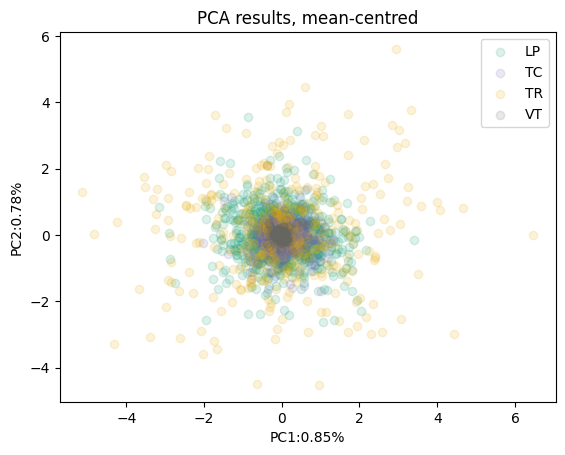

In [21]:
pca = PCA(n_components=2)
scrs = pca.fit_transform(train_data)

#plt.scatter(scrs[:,0], scrs[:,1], c=train_labs)
scatter_plot(scrs,train_labs,label_dict)
plt.title('PCA results, mean-centred')
plt.xlabel(f'PC1:{pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'PC2:{pca.explained_variance_ratio_[1]*100:.2f}%')
plt.show()

UMAP(min_dist=0.6, n_neighbors=5, verbose=True)
Fri Jan 26 18:32:37 2024 Construct fuzzy simplicial set
Fri Jan 26 18:32:44 2024 Finding Nearest Neighbors
Fri Jan 26 18:32:44 2024 Finished Nearest Neighbor Search
Fri Jan 26 18:32:44 2024 Construct embedding


Epochs completed:  12%| █▏         62/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  44%| ████▍      220/500 [00:02]

	completed  150  /  500 epochs
	completed  200  /  500 epochs


Epochs completed:  61%| ██████     306/500 [00:02]

	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed:  93%| █████████▎ 465/500 [00:02]

	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]


Fri Jan 26 18:32:46 2024 Finished embedding


Epochs completed: 100%| ██████████ 100/100 [00:01]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs



/tmp/ipykernel_2058676/4253029996.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


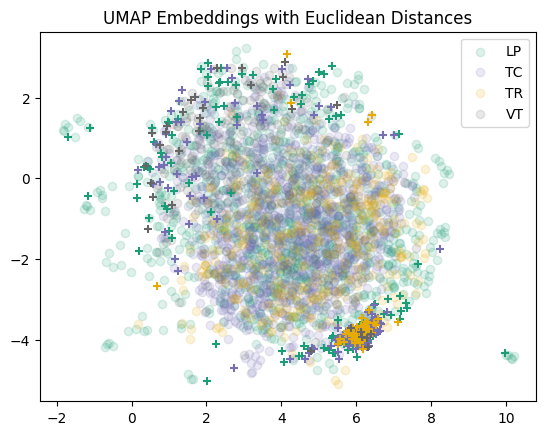

In [22]:
scaler = preprocessing.MinMaxScaler().fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

reducer_euclidean = umap.UMAP(n_components=2,
                              n_neighbors=5,
                              min_dist=0.6,
                              metric='euclidean',
                              verbose=True)

train_embds = reducer_euclidean.fit(train_data)
test_embds = reducer_euclidean.transform(test_data)

#plt.scatter(train_embds.embedding_[:,0],train_embds.embedding_[:,1],c=train_labs,alpha=0.1)
scatter_plot(train_embds.embedding_,train_labs,label_dict)
#plt.scatter(test_embds[:,0],test_embds[:,1],c=test_labs,marker='+')
scatter_plot(test_embds,test_labs,label_dict,train=False)
plt.title('UMAP Embeddings with Euclidean Distances')
plt.show()

UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.6, n_neighbors=5, verbose=True)
Fri Jan 26 18:32:54 2024 Construct fuzzy simplicial set
Fri Jan 26 18:33:31 2024 Finding Nearest Neighbors
Fri Jan 26 18:33:31 2024 Finished Nearest Neighbor Search
Fri Jan 26 18:33:31 2024 Construct embedding


Epochs completed:   6%| ▋          32/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  50%| █████      252/500 [00:01]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  78%| ███████▊   392/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]

	completed  450  /  500 epochs
Fri Jan 26 18:33:33 2024 Finished embedding



Epochs completed: 100%| ██████████ 100/100 [00:01]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs



/tmp/ipykernel_2058676/4253029996.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


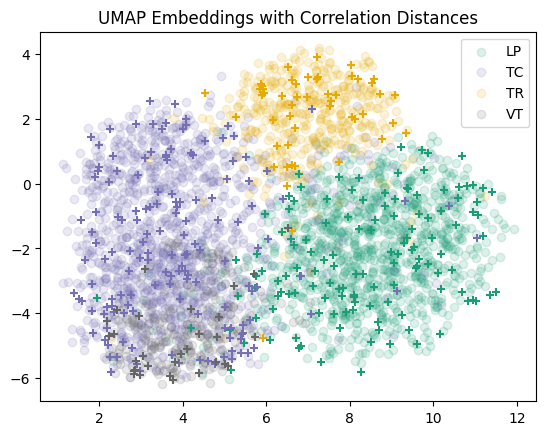

In [23]:
reducer_correlation = umap.UMAP(n_components=2,
                    n_neighbors=5,
                    min_dist=0.6,
                    metric='correlation',
                    verbose=True)

train_embds = reducer_correlation.fit(train_data)
test_embds = reducer_correlation.transform(test_data)

#plt.scatter(train_embds.embedding_[:,0],train_embds.embedding_[:,1],c=train_labs,alpha=0.1)

#plt.scatter(test_embds[:,0],test_embds[:,1],c=test_labs,marker='+')

scatter_plot(train_embds.embedding_,train_labs,label_dict,train=True)
scatter_plot(test_embds,test_labs,label_dict,train=False)
plt.title('UMAP Embeddings with Correlation Distances')
plt.show()

Epochs completed: 100%| ██████████ 100/100 [01:24]


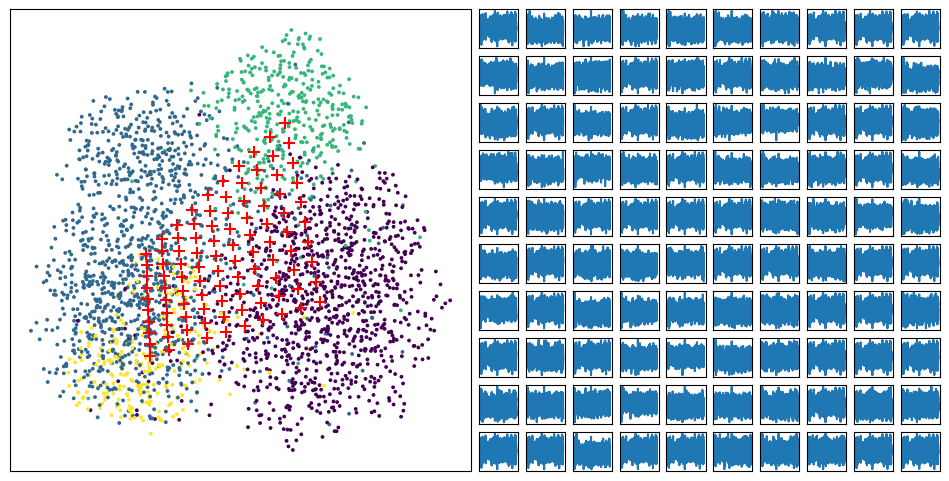

In [80]:
#find means of each class
clusters = np.unique(train_labs)

cluster_means = np.zeros((clusters.shape[0],2))

for cluster in clusters:
    cluster_embeddings = reducer_correlation.embedding_[train_labs == cluster]
    cluster_means[cluster,:] = np.mean(cluster_embeddings,axis=0)

#create convex quadrilateral
centred_coords = cluster_means - np.mean(cluster_means,axis=0)
thetas = np.arctan2(centred_coords[:,1],centred_coords[:,0])
order = np.argsort(thetas)

cluster_means = cluster_means[np.roll(order,1),:]

# adapted from umap-learn.readthedocs.io/en/latest/inverse_transform.html
test_points = np.array([
    (cluster_means[0]*(1-x) + cluster_means[3]*x)*(1-y) +
    (cluster_means[1]*(1-x) + cluster_means[2]*x)*y
    for y in np.linspace(0,1,10)
    for x in np.linspace(0,1,10)
])

#Find the inverse transform of the points and plot them
inv_transformed_points = scaler.inverse_transform(reducer_correlation.inverse_transform(test_points))

# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

scatter_ax.scatter(reducer_correlation.embedding_[:, 0], reducer_correlation.embedding_[:, 1],
                   c=train_labs, s=3)
scatter_ax.set(xticks=[], yticks=[])

scatter_ax.scatter(test_points[:, 0], test_points[:, 1], marker='+', c='r', s=75)

#plot the inverse transforms
for i in range(10):
    for j in range(10):
        digit_axes[i, j].plot(inv_transformed_points[i*10 + j,:].T)
        digit_axes[i, j].set(xticks=[], yticks=[])

plt.show()

/tmp/ipykernel_2058676/4253029996.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


Text(0.5, 1.0, 'MDS Embeddings with Correlation Distances')

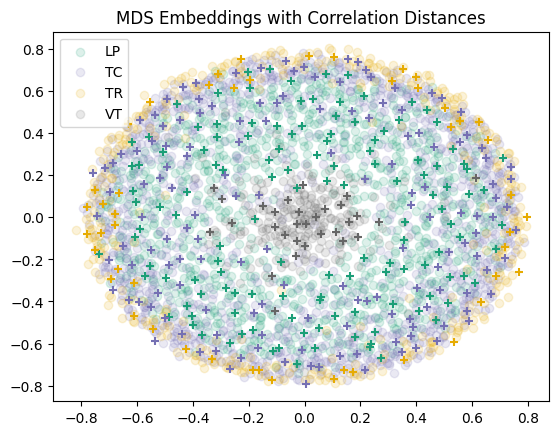

In [24]:
mds_reducer = MDS(n_components=2,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
    dissimilarity='precomputed')

train_data_correlation = squareform(pdist(train_data,'correlation'))
test_data_correlation = squareform(pdist(test_data,'correlation'))

mds_embeddings_train = mds_reducer.fit_transform(train_data_correlation)
mds_embeddings_test = mds_reducer.fit_transform(test_data_correlation)

#plt.scatter(mds_embeddings_train[:,0],mds_embeddings_train[:,1],c=train_labs,alpha=0.1)
scatter_plot(mds_embeddings_train,train_labs,label_dict,train=True)
#plt.scatter(mds_embeddings_test[:,0],mds_embeddings_test[:,1],c=test_labs,marker='+')
scatter_plot(mds_embeddings_test,test_labs,label_dict,train=False)

plt.title('MDS Embeddings with Correlation Distances')